In [1]:
from scipy.signal import butter, filtfilt
import os
from scipy.fft import fft, ifft
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import statistics
import bvp_onsets_repair as bor
#from biosppy.signals import ppg
#from biosppy.signals import bvp
import math 
from scipy.ndimage import gaussian_filter
#import biosppy.signals as bps
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks

display(HTML("<style>.container { width:70% !important; }</style>"))

## IQR Filter

In [6]:
df = []

for i in range(30):
    temp_df = pd.read_csv(f"C:/mgr/_datasets/csv/data{i+1}.csv")
    df.append(temp_df)



for i in range(len(df)):
    Q1, Q3 = np.percentile(df[i]['BVP'], [25, 75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[i]['BVP_clean'] = df[i]['BVP']
    df[i].loc[df[i]['BVP_clean'] < lower_bound, 'BVP_clean'] = lower_bound
    df[i].loc[df[i]['BVP_clean'] > upper_bound, 'BVP_clean'] = upper_bound

Text(0.5, 1.0, 'Non filtered BVP signal')

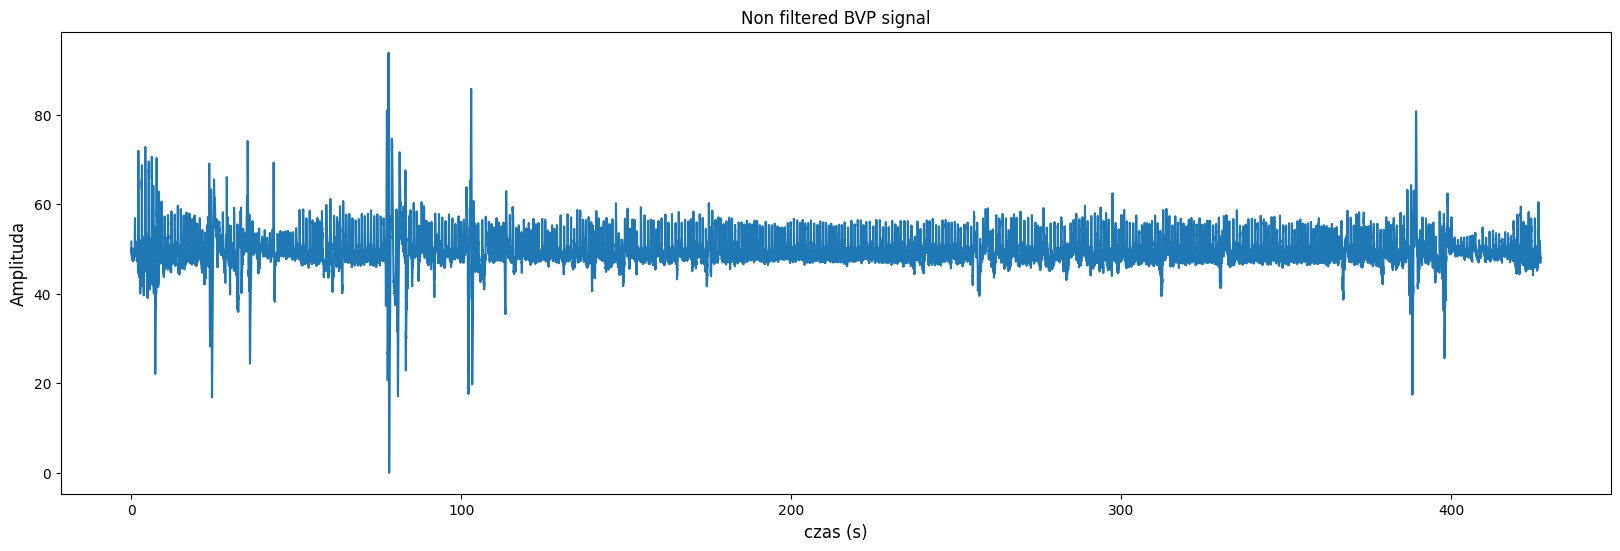

In [7]:
interval = 1/40
y = df[16]["BVP"][:-25000]
plt.figure(figsize=(20,6))
time_array = np.arange(len(gaussian_filter(y, sigma= 50))) * interval
plt.plot(time_array, y)

plt.ylabel("Amplituda", fontsize = 12)
plt.xlabel("czas (s)",fontsize = 12)
plt.title("Non filtered BVP signal")

Text(0.5, 1.0, 'IQR filtered BVP signal')

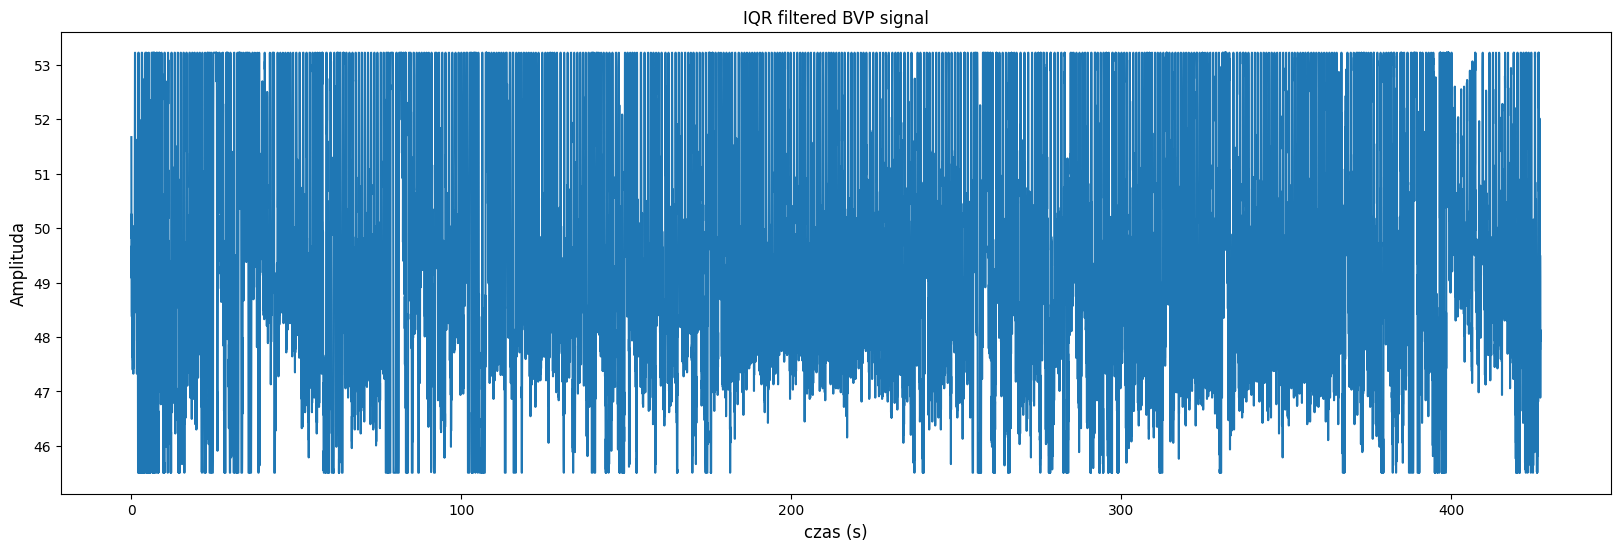

In [8]:
interval = 1/40
plt.figure(figsize=(20,6))
time_array = np.arange(len(gaussian_filter(df[16]["BVP_clean"][:-25000], sigma= 50))) * interval
plt.plot(time_array, df[16]["BVP_clean"][:-25000])

plt.ylabel("Amplituda", fontsize = 12)
plt.xlabel("czas (s)",fontsize = 12)
plt.title("IQR filtered BVP signal")

## Variance filter to get rid of flat segments in BVP signal

In [9]:


new_df = []
def connect_signal(signal, window_size, lower_thresh, upper_thresh, df):
    # Moving variance 
    variances = np.zeros(len(signal))
    for i in range(len(signal)):
        if i < window_size:
            variances[i] = np.var(signal[:i+1])
        else:
            variances[i] = np.var(signal[i-window_size+1:i+1])

    # Treshold cutoff
    below_lower_thresh = variances < lower_thresh
    above_upper_thresh = variances > upper_thresh
    print(below_lower_thresh)
    # Remove missing parts of the signal
    signal = signal[~np.isnan(signal)]
    below_thresh = np.logical_or(below_lower_thresh, above_upper_thresh)[~np.isnan(signal)]

    # Interpolation of missing parts
    interp_signal = np.interp(
        np.arange(len(signal)),
        np.arange(np.sum(~below_thresh)),
        signal[~below_thresh],
        left=np.nan,
        right=np.nan
    )

    # Connecting parts where signal was deleted
    tapering_func = np.ones(len(signal))
    for i in range(window_size):
        tapering_func[i] = (i + 1) / window_size
        tapering_func[-i-1] = (i + 1) / window_size
    interp_signal *= tapering_func

    # Remove parts below the lower threshold or above the upper threshold and connect the remaining segments
    connected_signal = np.zeros(len(signal))
    segment_start = 0
    for i in range(len(below_thresh)):
        if i == len(below_thresh) - 1 or below_thresh[i] != below_thresh[i+1]:
            segment_end = i
            segment_signal = interp_signal[segment_start:segment_end+1]
            connected_signal[segment_start:segment_end+1] = segment_signal
            segment_start = i + 1
            
    # Creating a new dataframe 
    if df is not None:
        index_arr = np.arange(len(signal))[~np.isnan(signal)]
        index_arr = index_arr[below_thresh]
        mask = df.index.isin(index_arr) & df['Marker'].isna()
        df = df[~mask]
        new_df.append(df)

    return connected_signal

## Frequency filter to get rid of unwanted frequencies

In [10]:
sampling_rate = 40  
nyquist_freq = 0.5 * sampling_rate  
cutoff_low = .5  
cutoff_high = 3  
order = 4  
b, a = butter(order, [cutoff_low/nyquist_freq, cutoff_high/nyquist_freq], btype='bandpass')


Text(0.5, 0, 'Czas (s)')

<Figure size 3000x600 with 0 Axes>

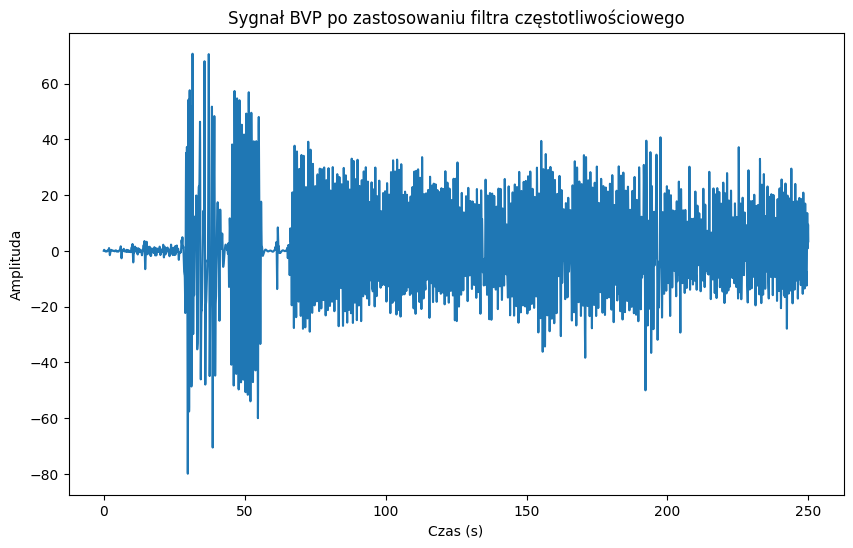

In [11]:
interval = 1/40
plt.figure(figsize=(30,6))
time_array = np.arange(len(gaussian_filter(df[10]["BVP_clean"][0:10000], sigma= 50))) * interval
plt.figure(figsize=(10,6))
plt.plot(time_array, filtfilt(b, a, df[10]["BVP_clean"][0:10000]))
plt.title("Sygnał BVP po zastosowaniu filtra częstotliwościowego")
plt.ylabel("Amplituda")
plt.xlabel("Czas (s)")

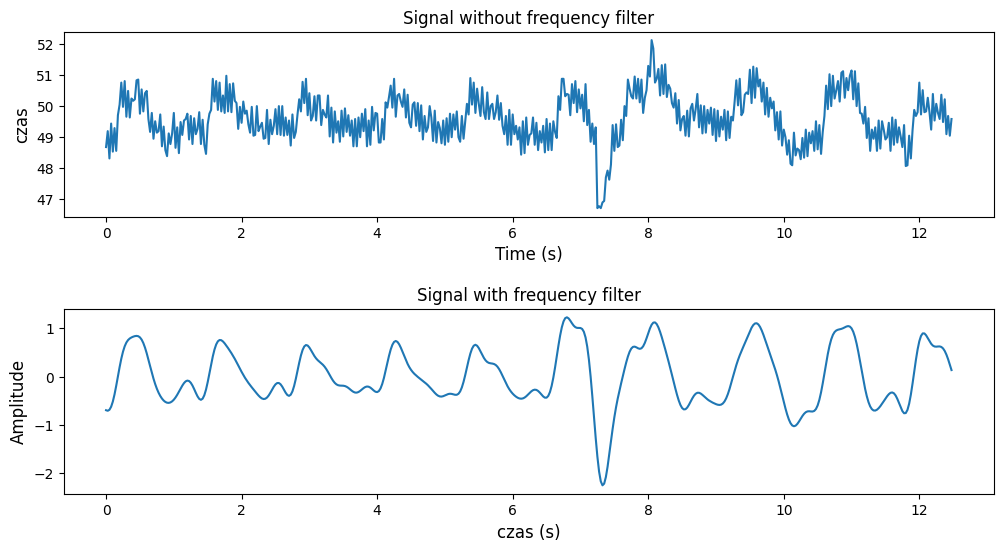

In [27]:
plt.figure(figsize=(12, 6))


interval = 1/40  
time_array = np.arange(len(gaussian_filter(df[7]["BVP_clean"][4000:4500], sigma=50))) * interval

# Plot the first subplot
plt.subplot(2, 1, 1)
plt.plot(time_array, df[7]["BVP_clean"][4000:4500])
plt.ylabel("czas", fontsize=12)
plt.xlabel("Time (s)", fontsize=12)
plt.title("Signal without frequency filter")

# Plot the second subplot
plt.subplot(2, 1, 2)
plt.plot(time_array, example[4000:4500])
plt.ylabel("Amplitude", fontsize=12)
plt.xlabel("czas (s)", fontsize=12)
plt.title("Signal with frequency filter")

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Display the plot
plt.show()

In [20]:
import numpy as np
new_bvp = []
new_df = []*30
for i in range(len(df)):
    bvp_signal = df[i]["BVP_clean"]
    denoised_signal = filtfilt(b, a, bvp_signal)
    if i == 7:
        example = denoised_signal
    new_bvp.append(connect_signal(denoised_signal, 50, np.var(bvp_signal)/10, 10000000000, df[i]))
    new_bvp[i] = new_bvp[i][np.logical_not(np.isnan(new_bvp[i]))]




[ True  True False ... False False False]
[ True  True False ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True False ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False

## Calculate puls from BVP signal

In [23]:
from scipy.interpolate import interp1d
FREQ = 40.0
pulse_list = []
licznik = 0
for i in new_bvp:
    licznik += 0
    bvp_filtered = i
    t = np.linspace(0,len(bvp_filtered)/FREQ,len(bvp_filtered))
    peaks, _ = find_peaks(bvp_filtered, height=0.5, distance=20)
    pulse = []
    pulse_signal = np.zeros(len(bvp_filtered))
    for i in range(0, len(bvp_filtered)-len(bvp_filtered)%200, 200):
 
        segment = bvp_filtered[i:i+200]
        
   
        peaks, _ = find_peaks(segment, distance=20)
        if licznik == 19:
            plt.plot(t, bvp_filtered)
            plt.figure(figsize=(20,6))
            plt.plot(t[peaks], bvp_filtered[peaks], 'x', color='red')

  
        pulse = 60 / np.mean(np.diff(peaks)) * 40
        
      
        pulse_signal[i:i+200] = pulse
        

    valid_indices = ~np.isnan(pulse_signal)
    pulse_interp = interp1d(np.arange(valid_indices.sum()), pulse_signal[valid_indices], kind='cubic')
    pulse_signal[valid_indices] = pulse_interp(np.arange(valid_indices.sum()))
    pulse_list.append(pulse_signal)





## Comparasion between filtered and unfiltered signal

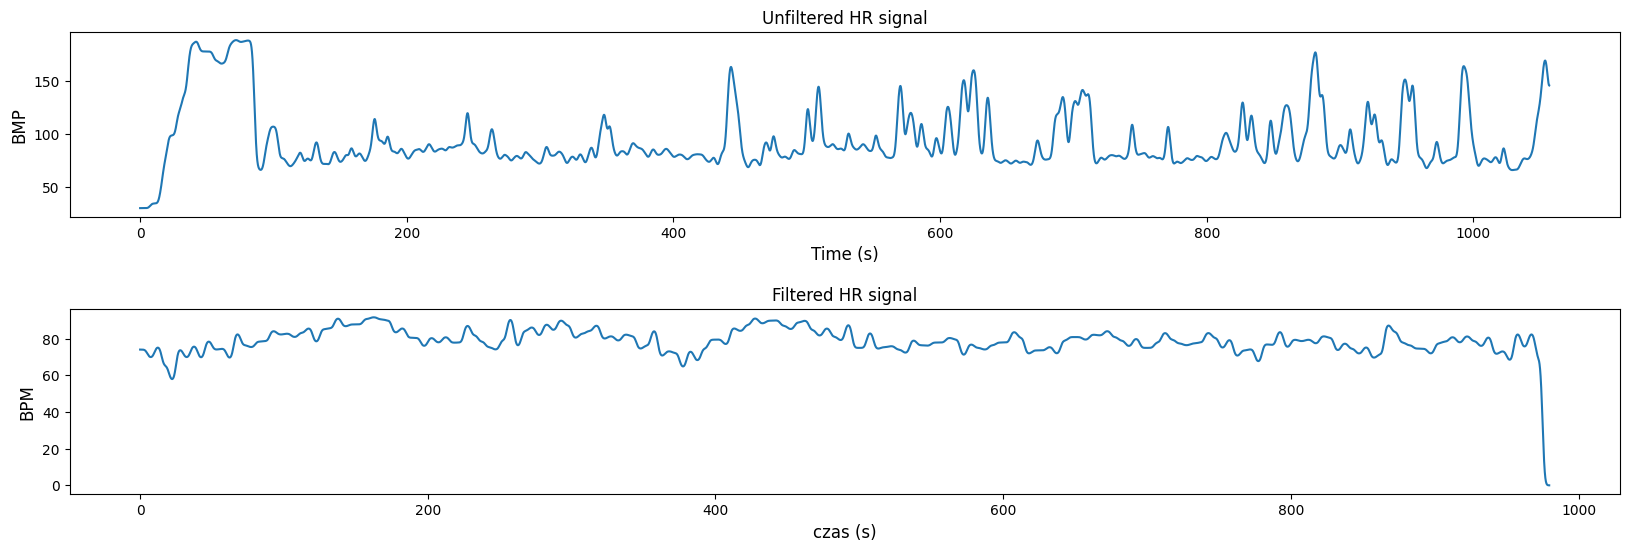

In [32]:
plt.figure(figsize=(20,6))
time_array = np.arange(len(gaussian_filter(df[19]["Pulse"], sigma= 50))) * interval

plt.subplot(2, 1, 1)
plt.plot(time_array, gaussian_filter(df[19]["Pulse"], sigma= 50))
plt.ylabel("BMP", fontsize=12)
plt.xlabel("Time (s)", fontsize=12)
plt.title("Unfiltered HR signal")

time_array = np.arange(len(pulse_list[19])) * interval
plt.subplot(2, 1, 2)
plt.plot(time_array, gaussian_filter(pulse_list[19], sigma= 50))
plt.ylabel("BPM", fontsize=12)
plt.xlabel("czas (s)", fontsize=12)
plt.title("Filtered HR signal")


plt.subplots_adjust(hspace=0.5)



Text(0.5, 0, 'Czas (s)')

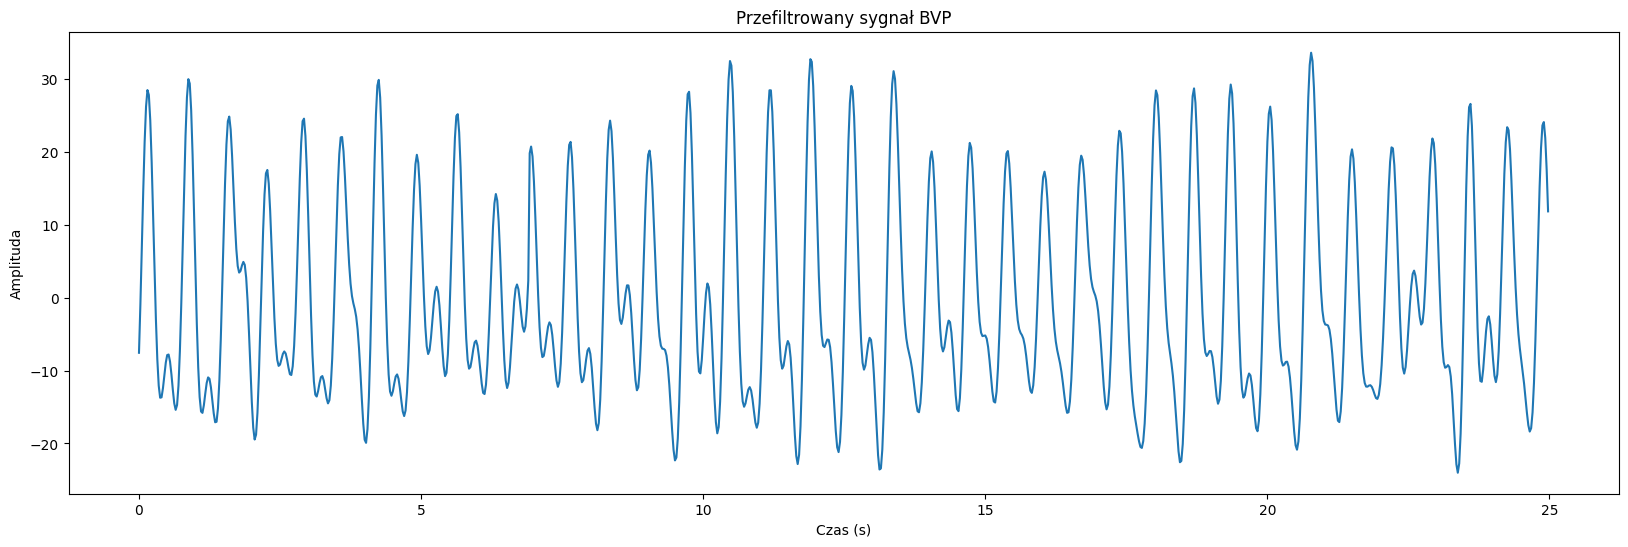

In [18]:
plt.figure(figsize=(20,6))


time_array = np.arange(len(new_bvp[10][2000:3000])) * interval
plt.plot(time_array, new_bvp[10][2000:3000])
plt.title("Przefiltrowany sygnał BVP")
plt.ylabel("Amplituda")
plt.xlabel("Czas (s)")